<a href="https://colab.research.google.com/github/JuanVelandia2702/CIENCIA_DATOS_2025/blob/main/PARTE1analisis_corte_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import json
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from scipy.stats import trim_mean

In [ ]:
with open("/content/drive/MyDrive/Analisis Ciencia De Datos 2025/fafafafaffaf.json", "r") as f:
    data = json.load(f)
# Extraer info de jugadores
partidas_data = []
for match_id, match in data.items():
    game_creation = match["info"]["gameCreation"]
    game_duration = match["info"]["gameDuration"]
    game_mode = match["info"].get("gameMode")



    for p in match["info"]["participants"]:
        partidas_data.append({
            "gameId": match_id,
            "gameCreation": pd.to_datetime(game_creation, unit="ms"),
            "riotIdGameName": p.get("riotIdGameName"),
            "championName": p.get("championName"),
            "kills": p.get("kills"),
            "deaths": p.get("deaths"),
            "assists": p.get("assists"),
            "totalDamageDealtToChampions": p.get("totalDamageDealtToChampions"),
            "goldEarned": p.get("goldEarned"),
            "win": p.get("win"),
            "teamId": p.get("teamId"),
            "lane": p.get("lane"),
            "role": p.get("role"),
            "teamPosition": p.get("teamPosition"),
            "gameMode": game_mode,
            "gameDuration": game_duration
        })

# Convertir a DataFrame
df_partidas = pd.DataFrame(partidas_data)

print(df_partidas.head())

           gameId            gameCreation  riotIdGameName  championName  \
0  LA1_1637649435 2025-07-28 18:47:09.111    XxPERCIBALxX  Heimerdinger   
1  LA1_1637649435 2025-07-28 18:47:09.111          Laozen       Warwick   
2  LA1_1637649435 2025-07-28 18:47:09.111      Elput4sPNG        Veigar   
3  LA1_1637649435 2025-07-28 18:47:09.111        HALFSTER   MissFortune   
4  LA1_1637649435 2025-07-28 18:47:09.111  KProject Blink        Velkoz   

   kills  deaths  assists  totalDamageDealtToChampions  goldEarned    win  \
0      4      10       25                        55719       16263  False   
1     16      17       13                        42488       19210  False   
2     13      11       11                        59092       19645  False   
3     13       9       17                        47155       19529  False   
4      4      20       14                        37321       13309  False   

   teamId    lane     role teamPosition gameMode  gameDuration  
0     100  JUNGLE    

In [ ]:
df_partidas["duracion_min"] = df_partidas["gameDuration"] / 60

In [ ]:
df_partidas["KDA"] = (df_partidas["kills"] + df_partidas["assists"]) / df_partidas["deaths"].replace(0, 1)

In [ ]:
# Filtrar las partidas del jugador
jugador = "Elput4sPNG"
harry = df_partidas[df_partidas["riotIdGameName"] == jugador]

In [ ]:
promedios = (
    harry
    .groupby("lane")
    .agg(KDA_promedio=("KDA", "mean"),Partidas=("KDA", "count"))
    .reset_index()
    .sort_values(by="KDA_promedio", ascending=True)
)
promedios

,lane,KDA_promedio,Partidas
3,NONE,1.325758,11
0,BOTTOM,1.754587,7
4,TOP,2.474654,17
2,MIDDLE,2.601464,56
1,JUNGLE,3.866270,9


In [ ]:
def fase_partida(duracion):
    if duracion < 20:
        return "Early"
    elif duracion < 30:
        return "Mid"
    else:
        return "Late"

harry["fase_juego"] = harry["duracion_min"].apply(fase_partida)


/tmp/ipython-input-2398655232.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  harry["fase_juego"] = harry["duracion_min"].apply(fase_partida)


In [ ]:
champion_counts = harry["championName"].value_counts()
print(champion_counts.head())

championName
Veigar         23
AurelionSol    19
Ekko            9
Shen            9
Galio           4
Name: count, dtype: int64


In [ ]:
frequent_champions = champion_counts[champion_counts > 3].index
harry_filtered = harry[harry["championName"].isin(frequent_champions)]
print(harry_filtered["championName"].value_counts())

championName
Veigar         23
AurelionSol    19
Ekko            9
Shen            9
Galio           4
Yone            4
Volibear        4
Name: count, dtype: int64


Average Gold Earned by Champion and Game Phase:
   championName fase_juego  average_gold_earned
0   AurelionSol      Early          4325.666667
1   AurelionSol       Late         17810.833333
2   AurelionSol        Mid         10175.750000
3          Ekko       Late         12587.750000
4          Ekko        Mid          9420.000000
5         Galio      Early           852.000000
6         Galio       Late         13806.333333
7          Shen      Early          4422.000000
8          Shen       Late         12855.500000
9          Shen        Mid          7877.750000
10       Veigar       Late         18716.125000
11       Veigar        Mid         10143.428571
12     Volibear      Early           684.000000
13     Volibear       Late         12904.000000
14         Yone      Early          1020.000000
15         Yone       Late         17395.500000
16         Yone        Mid          6211.000000


In [ ]:
wins_losses_by_champion_phase = harry_filtered.groupby(['championName', 'fase_juego'])['win'].agg(
    Wins=lambda x: (x == True).sum(),
    Losses=lambda x: (x == False).sum()
).reset_index()

wins_losses_melted = wins_losses_by_champion_phase.melt(
    id_vars=['championName', 'fase_juego'],
    value_vars=['Wins', 'Losses'],
    var_name='Metric',
    value_name='Count'
)

# Represent losses as negative values for visualization
wins_losses_melted.loc[wins_losses_melted['Metric'] == 'Losses', 'Count'] = -wins_losses_melted['Count']

print("Wins and Losses by Champion and Game Phase (Melted Data):\n")
print(wins_losses_melted.head(10))

Wins and Losses by Champion and Game Phase (Melted Data):

  championName fase_juego Metric  Count
0  AurelionSol      Early   Wins      3
1  AurelionSol       Late   Wins      7
2  AurelionSol        Mid   Wins      2
3         Ekko       Late   Wins      2
4         Ekko        Mid   Wins      1
5        Galio      Early   Wins      0
6        Galio       Late   Wins      2
7         Shen      Early   Wins      0
8         Shen       Late   Wins      2
9         Shen        Mid   Wins      2


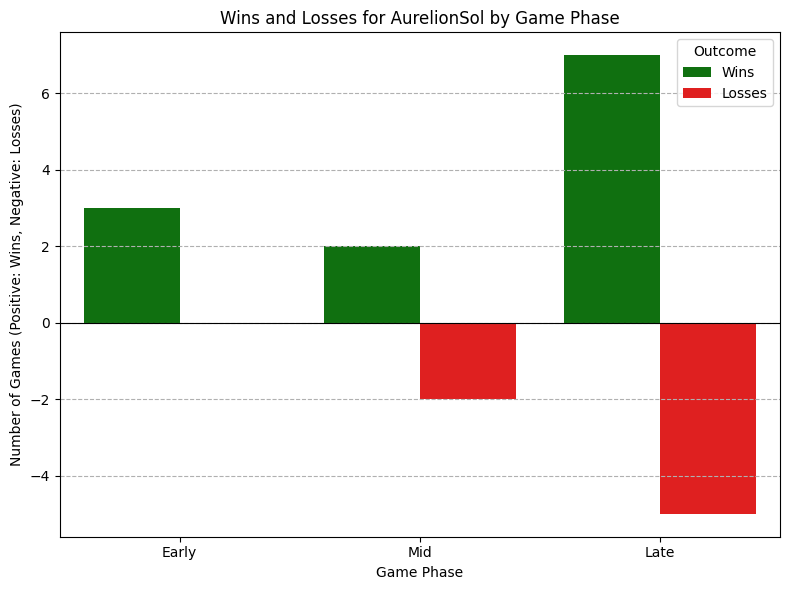

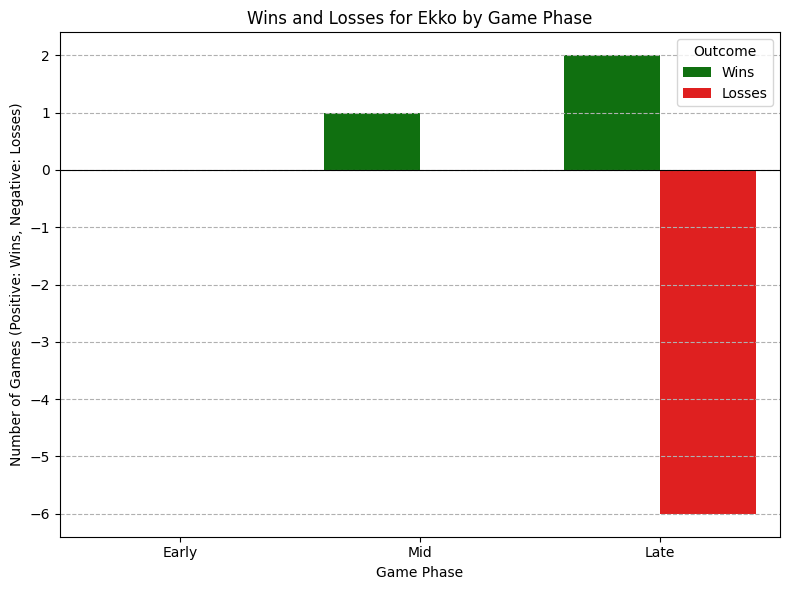

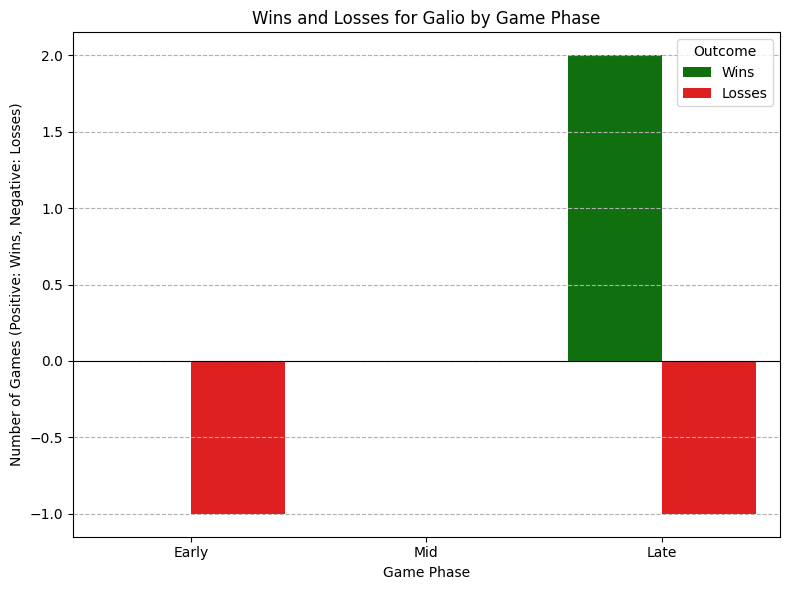

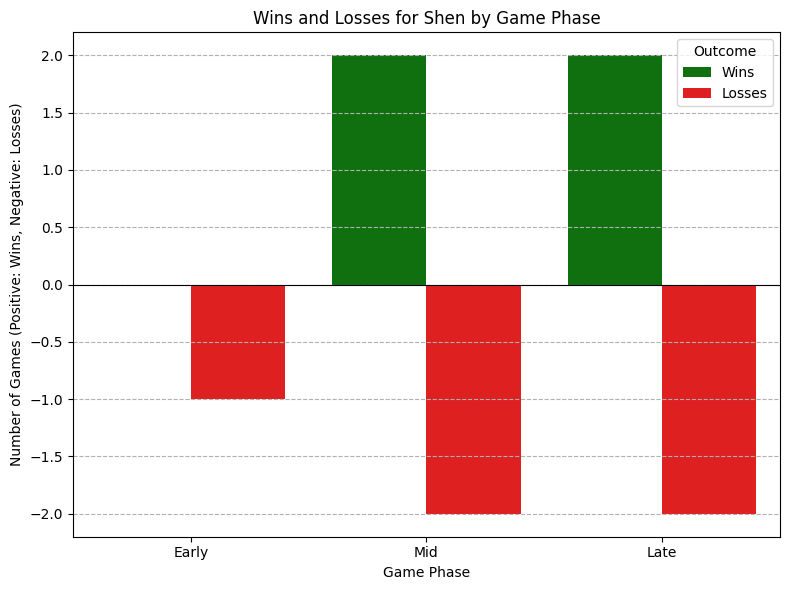

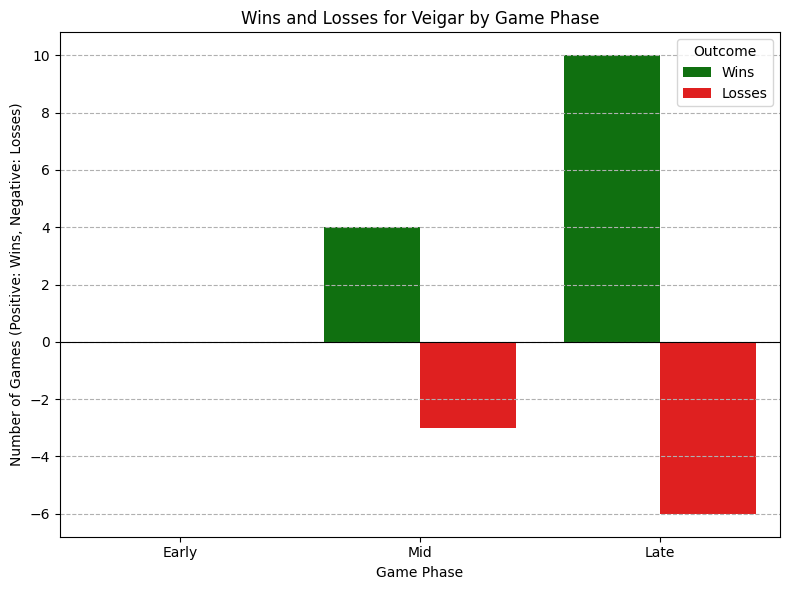

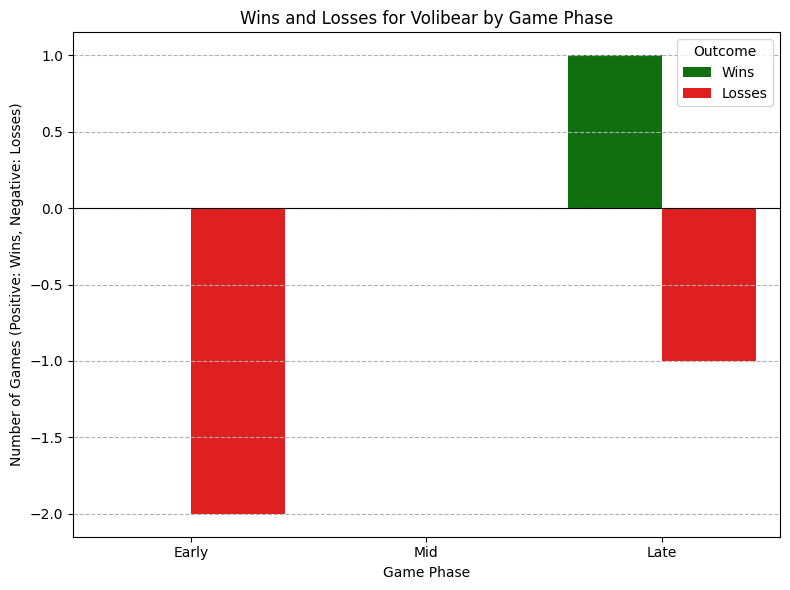

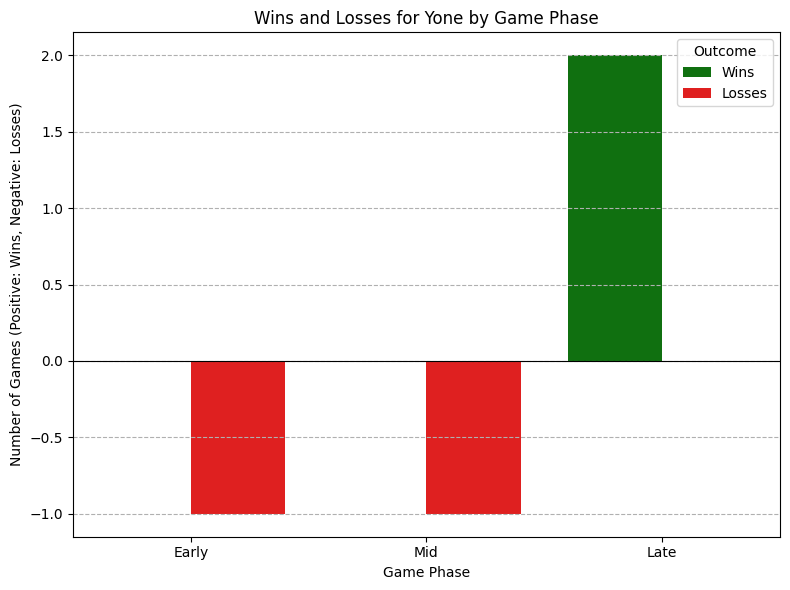

In [ ]:
# Get unique champion names from the melted data
unique_champions = wins_losses_melted['championName'].unique()

# Loop through each champion and create a separate plot
for champion in unique_champions:
    champion_data = wins_losses_melted[wins_losses_melted['championName'] == champion]

    plt.figure(figsize=(8, 6))
    sns.barplot(
        data=champion_data,
        x='fase_juego',
        y='Count',
        hue='Metric',
        palette={'Wins': 'green', 'Losses': 'red'},
        order=['Early', 'Mid', 'Late'] # Ensure consistent order of game phases
    )
    plt.title(f'Wins and Losses for {champion} by Game Phase')
    plt.xlabel('Game Phase')
    plt.ylabel('Number of Games (Positive: Wins, Negative: Losses)')
    plt.grid(axis='y', linestyle='--')
    plt.axhline(0, color='black', linewidth=0.8) # Add a line at y=0 for clarity
    plt.legend(title='Outcome')
    plt.tight_layout()
    plt.show()

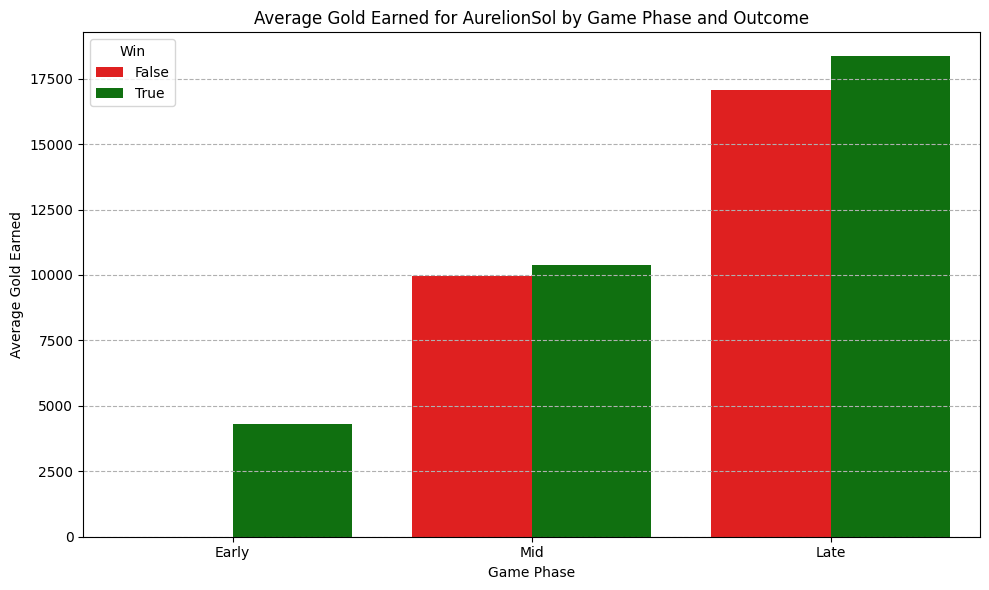

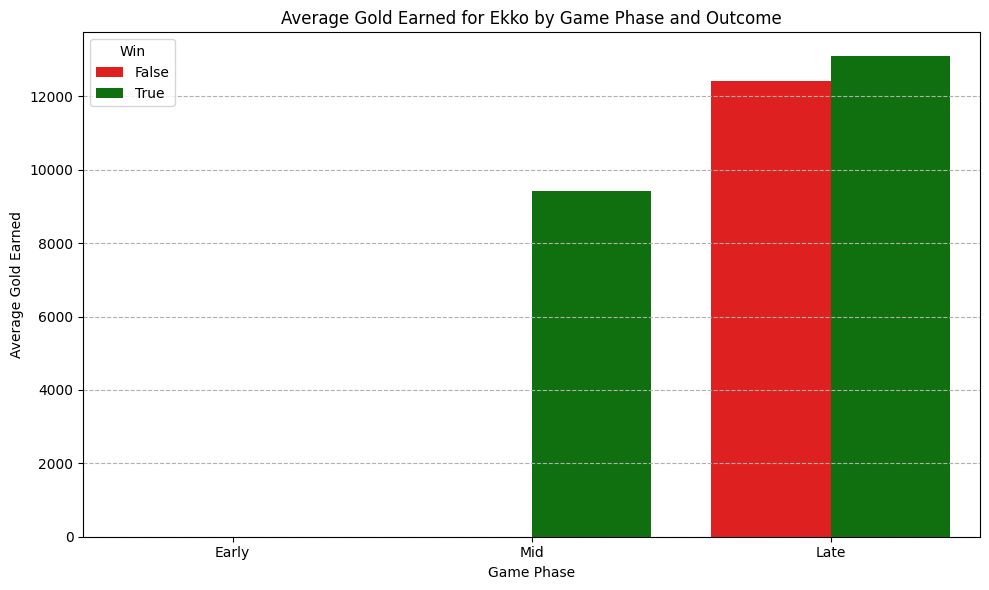

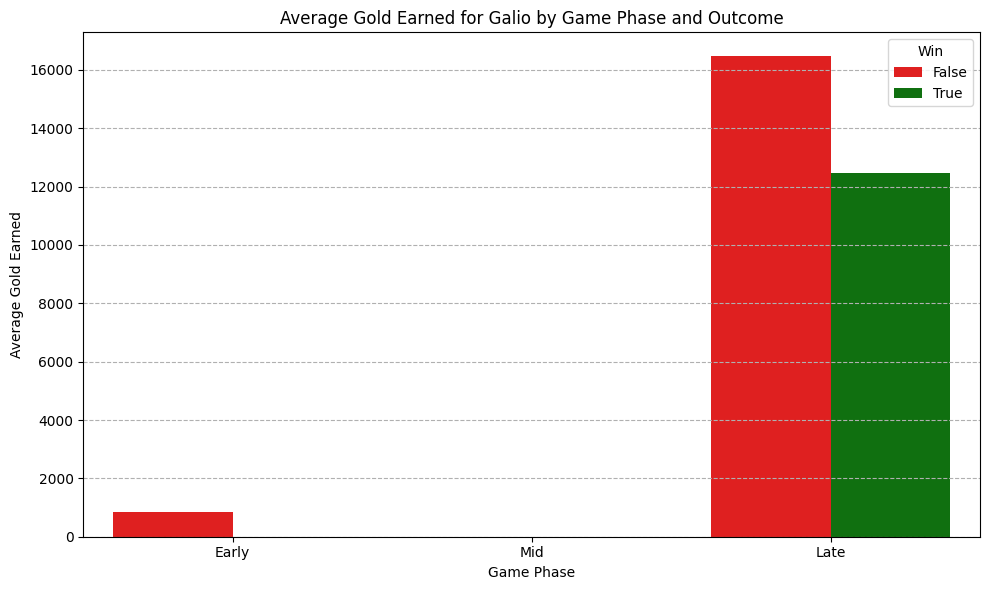

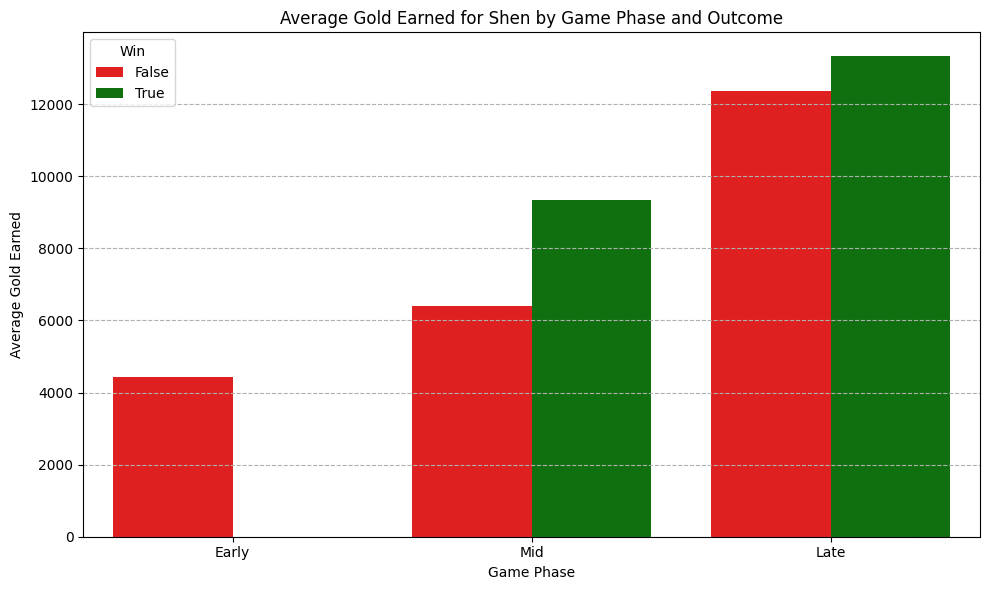

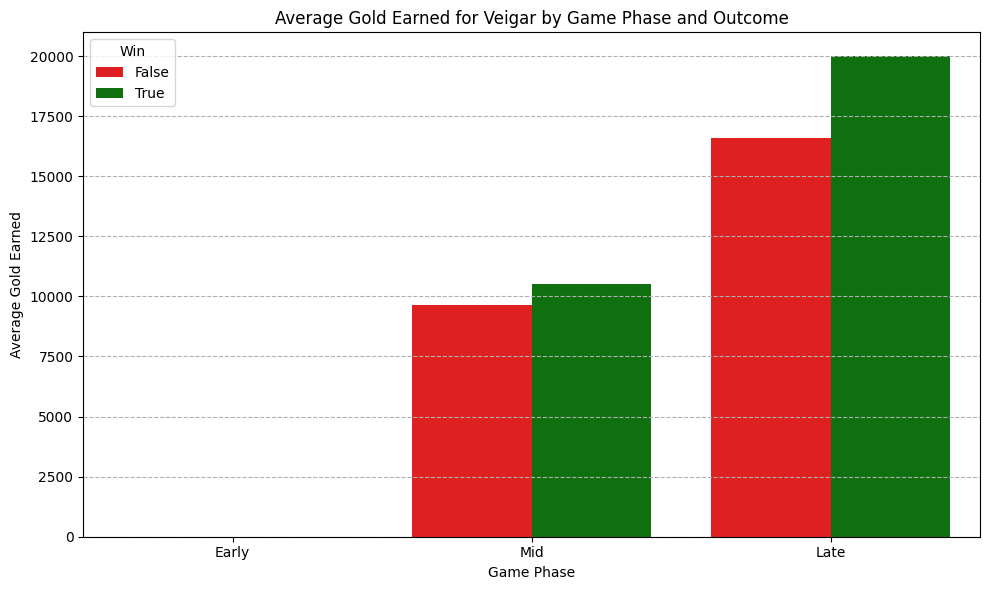

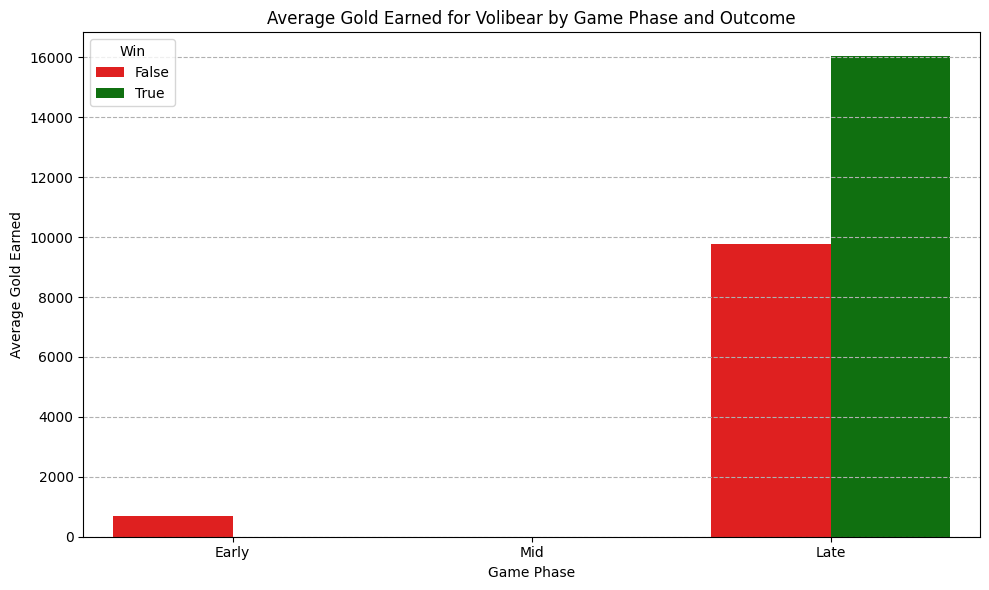

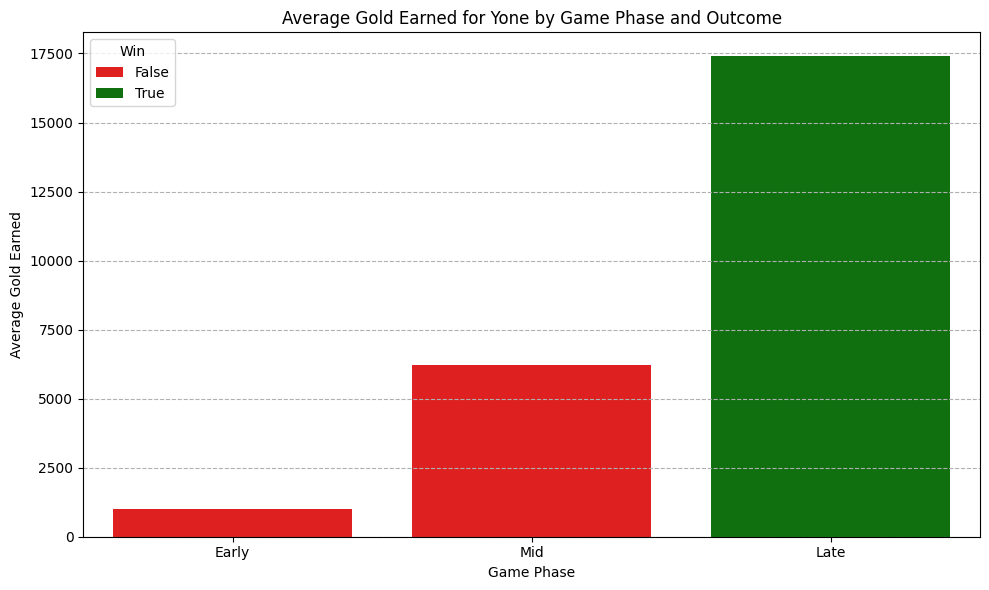

In [ ]:
unique_champions_gold = gold_by_champion_phase_outcome['championName'].unique()

for champion in unique_champions_gold:
    champion_gold_data = gold_by_champion_phase_outcome[gold_by_champion_phase_outcome['championName'] == champion]

    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=champion_gold_data,
        x='fase_juego',
        y='average_gold_earned',
        hue='win',
        palette={True: 'green', False: 'red'},
        order=['Early', 'Mid', 'Late']
    )
    plt.title(f'Average Gold Earned for {champion} by Game Phase and Outcome')
    plt.xlabel('Game Phase')
    plt.ylabel('Average Gold Earned')
    plt.legend(title='Win')
    plt.grid(axis='y', linestyle='--')
    plt.tight_layout()
    plt.show()

In [ ]:
teammates_data = []

jugador_principal = "Elput4sPNG"

for match_id, match in data.items():
    # Encontrar si el jugador principal está en esta partida y su teamId
    player_team_id = None
    for participant in match["info"]["participants"]:
        if participant.get("riotIdGameName") == jugador_principal:
            player_team_id = participant.get("teamId")
            break

    # Si el jugador principal está en la partida, encontrar a sus compañeros de equipo
    if player_team_id is not None:
        for participant in match["info"]["participants"]:
            if (participant.get("teamId") == player_team_id and
                participant.get("riotIdGameName") != jugador_principal):
                teammates_data.append({
                    "gameId": match_id,
                    "teammateRiotIdGameName": participant.get("riotIdGameName"),
                    "teammateChampionName": participant.get("championName")
                })

df_teammates = pd.DataFrame(teammates_data)

print(df_teammates.head())

           gameId teammateRiotIdGameName teammateChampionName
0  LA1_1637649435           XxPERCIBALxX         Heimerdinger
1  LA1_1637649435                 Laozen              Warwick
2  LA1_1637649435               HALFSTER          MissFortune
3  LA1_1637649435         KProject Blink               Velkoz
4  LA1_1637640560                Ruffles              Warwick


In [ ]:
frequent_teammates = df_teammates['teammateRiotIdGameName'].value_counts()

print("Top 10 most frequent teammates of Elput4sPNG:\n")
print(frequent_teammates.head(10))

Top 10 most frequent teammates of Elput4sPNG:

teammateRiotIdGameName
w4rry              11
Migumi              3
yeuux31             3
Mr Cosiaco          3
KOOMCAAC            2
Zprout              2
Plasmodium1010      2
  Crizzlynn D       2
Kaneky1485          2
EL Ing Hímerise     2
Name: count, dtype: int64


/tmp/ipython-input-484521990.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=frequent_teammates.head(10).index, y=frequent_teammates.head(10).values, palette='viridis')


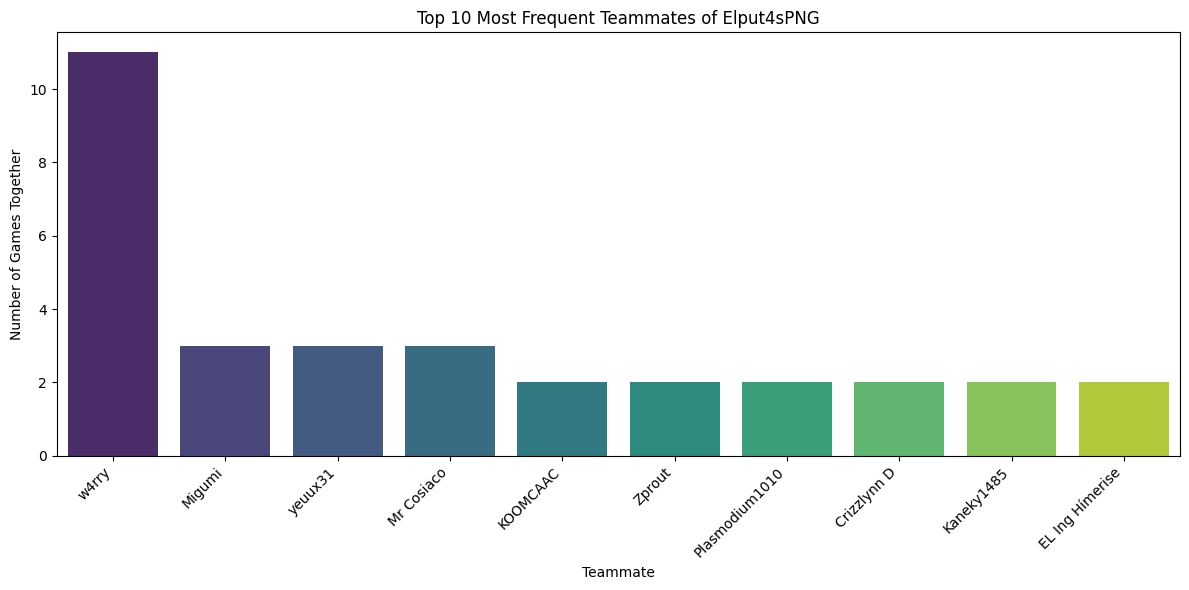

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x=frequent_teammates.head(10).index, y=frequent_teammates.head(10).values, palette='viridis')
plt.title('Top 10 Most Frequent Teammates of Elput4sPNG')
plt.xlabel('Teammate')
plt.ylabel('Number of Games Together')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



In [ ]:
merged_df = pd.merge(df_teammates, harry, on='gameId', how='inner')
print(merged_df.head())

           gameId teammateRiotIdGameName teammateChampionName  \
0  LA1_1637649435           XxPERCIBALxX         Heimerdinger   
1  LA1_1637649435                 Laozen              Warwick   
2  LA1_1637649435               HALFSTER          MissFortune   
3  LA1_1637649435         KProject Blink               Velkoz   
4  LA1_1637640560                Ruffles              Warwick   

             gameCreation riotIdGameName championName  kills  deaths  assists  \
0 2025-07-28 18:47:09.111     Elput4sPNG       Veigar     13      11       11   
1 2025-07-28 18:47:09.111     Elput4sPNG       Veigar     13      11       11   
2 2025-07-28 18:47:09.111     Elput4sPNG       Veigar     13      11       11   
3 2025-07-28 18:47:09.111     Elput4sPNG       Veigar     13      11       11   
4 2025-07-28 17:54:49.487     Elput4sPNG        Galio      5       9       18   

   totalDamageDealtToChampions  ...    win  teamId    lane  role teamPosition  \
0                        59092  ...  Fals

In [ ]:
teammate_win_rates = merged_df.groupby('teammateRiotIdGameName').agg(
    total_games=('gameId', 'nunique'),
    wins=('win', lambda x: (x == True).sum())
).reset_index()

teammate_win_rates['win_rate'] = (teammate_win_rates['wins'] / teammate_win_rates['total_games']) * 100

frequent_teammate_win_rates = teammate_win_rates[teammate_win_rates['total_games'] > 2]

top_10_individual_teammates = frequent_teammate_win_rates.sort_values(by='win_rate', ascending=False).head(10)

print("Top 10 Individual Teammates by Win Rate (played > 2 games):")
print(top_10_individual_teammates)

Top 10 Individual Teammates by Win Rate (played > 2 games):
    teammateRiotIdGameName  total_games  wins   win_rate
173                 Migumi            3     1  33.333333
178             Mr Cosiaco            3     1  33.333333
369                yeuux31            3     1  33.333333
362                  w4rry           11     3  27.272727


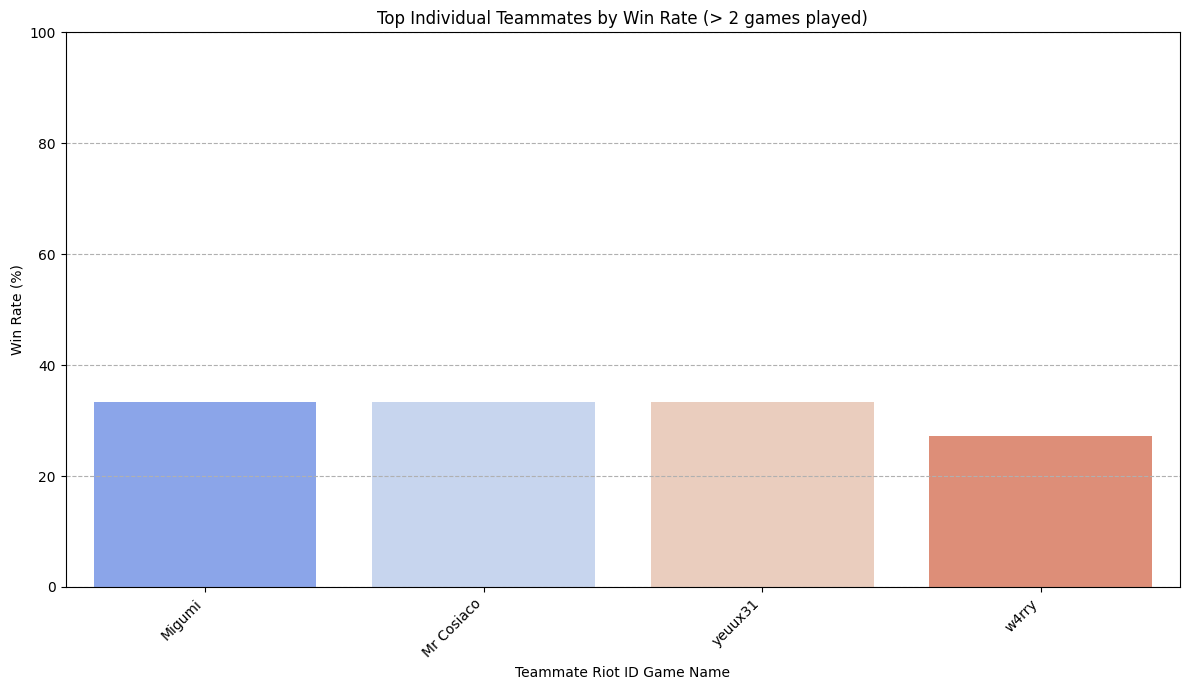

In [ ]:
plt.figure(figsize=(12, 7))
sns.barplot(x='teammateRiotIdGameName', y='win_rate', data=top_10_individual_teammates, palette='coolwarm', hue='teammateRiotIdGameName', legend=False)
plt.title('Top Individual Teammates by Win Rate (> 2 games played)')
plt.xlabel('Teammate Riot ID Game Name')
plt.ylabel('Win Rate (%)')
plt.ylim(0, 100)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()